# YouTube Machine Learning Model
###### Created by Randhir and Andrew
Hosted at https://github.com/CydiaBoss/YT-ML

### Project Introduction

The project focus chosen for this project is to collect data and use machine learning to find business insights. On the video-sharing website “YouTube”, “content creators,” or “channels,” can create and share videos on a diverse array of topics. A content creator will aim to produce a “successful” video, as videos with more views typically yield more monetary gain. There are several factors which can influence the success of a YouTube video. These include whether the YouTube video will be recommended by the YouTube recommendation algorithm, and, if the video is recommended, the likelihood that the video is clicked on by a user. This project will analyze the attributes that influence a user’s likelihood to click on a video. The main factors considered determining the success of a video are the video thumbnail, and the video title. These variables are chosen, as they are immediately visible to a user when a video is recommended. Measuring “success” in the data system can vary depending on the chosen methodology. For this project, the metric of “success” will be the engagement rate of the video. For more details, see the Data Description section.

Since there is such a diverse range of videos on YouTube, both in terms of the content covered and the relative popularity of the channels which produce these videos, it may be optimal to focus this analysis on a subgenre of videos. Thus, for this project, the subgenre of chess-related videos will be used. Information on video sampling and partitioning by subscriber count will be discussed in the Data Description section.

Using the information from the Problem Criteria, the following Problem Statement was created: _Which, if any, of thumbnail and video title affect the overall “success” of a YouTube video, using the subgenre of chess-related videos, where success is defined as a threshold for the number of likes and comments on a video relative to its view count?_

#### Imports
This cell contains all the necessary imports of the model.

In [1]:
import string, requests, os, json, math, re
import urllib.request
import urllib.error
from pathlib import Path

from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tf_keras.backend import clear_session
from tf_keras.callbacks import ModelCheckpoint, EarlyStopping
from tf_keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Concatenate, Input
from tf_keras.optimizers import Adam
from tf_keras.optimizers.schedules import ExponentialDecay
from tf_keras.utils import Sequence, plot_model
from tf_keras import Model
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from transformers import TFBertModel, BertTokenizer

import nltk
from nltk.corpus import stopwords

from dotenv import load_dotenv

# Load .env file with your api key
if not load_dotenv():
	print(".env file not found")

2024-12-02 12:27:14.776040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733160434.853798   27549 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733160434.879740   27549 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 12:27:15.083603: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/chairmanpooh/YT-ML/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update 

#### Constants
This cell contains the constants used by this model

In [2]:
# File Structure
dirpath = "thumbnail"
modeldir = "models"
datafile = "videos_df.parquet"

# Data Aquisition
filepath = "data.csv"
topic_id = "/m/03hf_rm" # Strategy Games
API_KEY = os.getenv("APIKEY")

# Data Filtering
filepath_final = "data-filtered.csv"
lang = "en"

# Labeling
MAX_VIEWS = 15.3e9 # Baby Shark Video (Most Viewed Video)
MAX_SUBS = 3.5e8 # MrBeast 
THRESHOLD = 0.025

# Regex Patterns
emoji_re = "[\U000000A9-\U0010ffff]"
punc_re = f"[{re.escape(string.punctuation)}]"
space_re = "\s{1,}"

# Download Stopwords & pattern
nltk.download('stopwords')
stopwords_list = stopwords.words("english")
sw_re = f'\b(?:{"|".join([f"{re.escape(sw)}" for sw in stopwords_list])})\b'

# Vectorization
vectorizator_model = "bert-base-uncased"
bert_tokenizer : BertTokenizer = BertTokenizer.from_pretrained(vectorizator_model)
bert_model : TFBertModel = TFBertModel.from_pretrained(vectorizator_model)
bert_model.trainable = False

# KFold Settings
n_folds = 5
epochs = 30
batch_size = 16
learning_rate = 1e-3

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/chairmanpooh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
I0000 00:00:1733160446.819203   27549 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initiali

### Data Description

This section will handle the data aquisition, data processing, and data filtering. The thumbnails will also be downloaded within this section.

#### Data Aquisition
To build a suitable model, it must be possible to collect data such as YouTube video thumbnails, video titles, video creator subscriber count, and many other statistics. Google’s YouTube API allows one to collect these metrics for specific videos.

To collect data for the sub-genre of “chess videos,” channel data was collected using the YouTube `search` API. The YouTube `search` API allows one to input a query, such as “chess”, and retrieves YouTube resources relevant to the query. To collect data for chess videos, it was decided to use the YouTube `search` API to first query channels using “chess” as the query search term. Channel data is being collected as querying video data for channel uploads is less expensive than querying videos using the `search` API itself.

After quering, the first step to cleaning the data involves filtering channels for language. Although the YouTube `search` API has a parameter `relevanceLanguage`, it is still necessary to filter for any non-English channels. To implement this, the `langdetect` library in Python was utilized, and language was detected by using a channel’s `description` field as an indicator for the language.

Once relevant channel data is collected, each channel’s video upload can be queried. In an attempt to avoid outliers, only a percentage of a channel’s latest uploads are pulled using the YouTube `playlistItem` API. The chosen percentage for this project is 20%, due to API quota limitations. The `playlistItem` API returns video thumbnail data, as well as the `video_id`, which can be used to query additional video statistics.

Finally, the videos obtained from the previous query can be queried using the `video` API to retrieve relevant video statistics. These include `viewCount`, `likeCount`, and `commentCount` which can each be used as data labels on which to train the model.

##### Utility Functions used for Data Fetching
The following functions are utility functions used to for data retrieval.

In [ ]:
# Utility function to fetch data from a URL
def fetch_url(url):
    try:
        response = urllib.request.urlopen(url)
        return response.read(), None
    except Exception as e:
        return None, e

def chan_id_to_upload_id(channel_id):
    return f"UU{channel_id[2:]}"

##### Retrieving Channel Data
The following functions are designed to grab channel data.

In [ ]:
# create the api channel search call given query and api key
def create_channel_search_call(q: str, API_KEY: str, pageToken=None,
                               part="snippet", type="channel", 
                               relevanceLanguage="en", maxResults="50",
                               order="date"):
    
    q = urllib.parse.quote_plus(q)
    url = f"https://www.googleapis.com/youtube/v3/search?part={part}&q={q}&type={type}&key={API_KEY}&relevanceLanguage={relevanceLanguage}&maxResults={maxResults}"
    if pageToken is None:
        return url 
    else:
        return f"{url}&pageToken={pageToken}"

# get data from "snippet" field of channel list query response, return None if detect non english
def get_channel_id_title(snippet, cols=('channelId', 'channelTitle', 'title')):
    desc = snippet.get('description', '')

    if desc == '' or detect(desc) == 'en':
        return {col: snippet.get(col, '') for col in cols}
    else:
        return None

# pull relevant data from channel search call
def clean_channel_search_data(raw_channels_data_dict, id_key='channelId'):
    res = {}
    for channel in raw_channels_data_dict['items']:
        curr_id_title = get_channel_id_title(channel['snippet'])
        if curr_id_title is not None:
            res[curr_id_title[id_key]] = curr_id_title

    return res

# retrieve statistics for channels
def create_channel_stats_call(channel_ids, API_KEY: str, part='statistics'):
    return f"https://youtube.googleapis.com/youtube/v3/channels?part={part}&key={API_KEY}&id={','.join(channel_ids)}"

# gets the sub count, video count and view count of a channel
def get_channel_stats(statistics, cols=('subscriberCount', 'videoCount', 'viewCount')):
    isSubCountHidden = statistics['hiddenSubscriberCount']

    if not isSubCountHidden:
        return {col: statistics.get(col, '') for col in cols}
    else:
        return None

# not necessary as the uploads playlist is the channel id prefixed with UU instead of UC
def get_channel_uploads_playlist(contentDetails):
    return contentDetails.get('relatedPlaylists', {}).get('uploads', None)

# pull relevant data from channel stats call
def clean_channel_stats_data(raw_channels_data_dict, id_key='channelId'):
    res = {}
    for channel in raw_channels_data_dict['items']:
        curr_id = channel['id']
        curr_stats = get_channel_stats(channel['statistics'])
        #curr_stats['uploads'] = get_channel_uploads_playlist(channel['contentDetails'])
        if curr_stats is not None:
            res[curr_id] = curr_stats

    return res

# call apis to get channel from search api and related statistics (views/subcount)
def get_combined_channel_data(pageToken, query, API_KEY, save_path):
    channel_search_call = create_channel_search_call(query, API_KEY, pageToken)
    raw_data, error = fetch_url(channel_search_call)
    channels_data = None
    nextPageToken = None
    if error is None:
        channels_data = json.loads(raw_data)
        print(channels_data)
        nextPageToken = channels_data['nextPageToken']
        channels_data = clean_channel_search_data(channels_data)
    else:
        raise error

    channel_stats_call = create_channel_stats_call(list(channels_data.keys()), API_KEY, part='statistics')
    raw_data, error = fetch_url(channel_stats_call)
    channels_stats_data = None
    if error is None:
        channels_stats_data = json.loads(raw_data)
        print(channels_stats_data)
        channels_stats_data = clean_channel_stats_data(channels_stats_data)
    else:
        raise error

    channels_data = pd.DataFrame.from_dict(channels_data, orient='index')
    channels_stats_data = pd.DataFrame.from_dict(channels_stats_data, orient='index')
    
    channels_combined_data = pd.merge(channels_data, channels_stats_data, left_index=True, right_index=True)
    channels_combined_data.to_parquet(f'{save_path}/nextPage_{nextPageToken}.parquet')

    return channels_combined_data, nextPageToken

To retrieve data for chess channels, run the following two functions. If "get_chess_channels_data" was stopped because of an API unit error, it can be rerun by providing the last "pageToken" that was queried. Each dataframe is saved in the format "nextPageToken".parquet.

In [ ]:
def get_chess_channel_data(API_KEY, save_path='./chess_channels', query='chess', pageToken=None, MAX_ITERATIONS=100):
    total_channels_retrieved = 0
    for _ in range(MAX_ITERATIONS):
        try:
            channel_data, pageToken = get_combined_channel_data(pageToken, query, API_KEY, save_path)
            print(channel_data)
            print(f'Pulled data for {len(channel_data)} channels.')
            total_channels_retrieved += len(channel_data)
        except Exception as e:
            print("Likely reached quota limit. Try again later.")
            print(f"Total # of channels pulled: {total_channels_retrieved}")
            print(e)
            break

def combine_channel_data(API_KEY, read_path='chess_channels', save_path='chess_channels_df.parquet'):
    df = pd.read_parquet(read_path)
    df['videoCount'] = df['videoCount'].astype(int)
    df = df.sort_values(by='videoCount', ascending=False)
    df = df.drop_duplicates()

    df.to_parquet(save_path)

##### Get All Uploads for Channels That Were Queried
Once channel data was pulled, their videos were queried.

In [ ]:
# Create URL call to query the youtube playListItems API
def create_upload_list_call(playlistId, API_KEY: str, 
                           pageToken=None, part="snippet", 
                           relevanceLanguage="en", maxResults="50"):
    
    url = f"https://www.googleapis.com/youtube/v3/playlistItems?playlistId={playlistId}&part={part}&key={API_KEY}&relevanceLanguage={relevanceLanguage}&maxResults={maxResults}"
    if pageToken is None:
        return url 
    else:
        return f"{url}&pageToken={pageToken}"
    
# Retrieve desired data from the channel uploads endpoint
def clean_uploads_video_data(raw_upload_videos_dict):
    res = {}
    for video in raw_upload_videos_dict['items']:
        snippet = video['snippet']
        id = snippet['resourceId']['videoId']
        curr_vid_data = {}
    
        # get video id and title
        curr_vid_data['videoId'] = id
        curr_vid_data['title'] = snippet['title']

        # get thumbnail details
        thumbnails = snippet['thumbnails']
        for thumb_type, data in thumbnails.items():
            # iterate over width, height, url fields
            for field, val in data.items():
                curr_vid_data[f'{thumb_type}_{field}'] = val

        res[id] = curr_vid_data

    return res

def get_channel_uploads_data(upload_id, nextPageToken, API_KEY: str, part="snippet"):
    videos_data = None
    
    url = create_upload_list_call(upload_id, API_KEY, nextPageToken, part=part)
    
    raw_data, error = fetch_url(url)

    if error is None:
        videos_data = json.loads(raw_data)
        #pprint(videos_data)
        nextPageToken = videos_data['nextPageToken']
        videos_data = clean_uploads_video_data(videos_data)
        #pprint(videos_data)
    else:
        raise error    
        
    videos_data = pd.DataFrame.from_dict(videos_data, orient='index')    
    return videos_data, nextPageToken

def get_all_channel_uploads(channel_id, max_pulls, API_KEY: str, part="snippet", save_folder_root='./chess_videos', nextPageToken=None):
    upload_id = chan_id_to_upload_id(channel_id)

    # check save folder location
    save_folder = f'{save_folder_root}/{channel_id}'
    if not os.path.exists(f'./{save_folder}'):
        os.mkdir(f'./{save_folder}')

    total_pulls = 0
    for _ in range(0, max_pulls, 50):
        try:
            videos_data, nextPageToken = get_channel_uploads_data(upload_id, nextPageToken, API_KEY)
            videos_data.to_parquet(f'{save_folder}/nextPage_{nextPageToken}.parquet')
            total_pulls += len(videos_data)

        except Exception as e:
            print('Likely ran out of units. Try again later.')
            print(e)
            break

    print(f"Total pulls: {total_pulls}")

Run the following function to retrieve video uploads assiociated with the previously queried channels.

In [ ]:
def patch_channel_uploads(API_KEY, read_path='chess_channels_df.parquet', pull_rate=0.2):
    channels_df = pd.read_parquet('chess_channels_df.parquet')
    channels_df = channels_df.sort_values(by='videoCount')

    # choose to pull the latest 20% of uploaded videos by default
    video_fraction = pull_rate

    for channel_id, row in channels_df.iterrows():
        print(f"Pulling data for channel: {row['title']}")
        get_all_channel_uploads(channel_id, math.ceil(row['videoCount']*video_fraction), API_KEY)

##### Patch Video Statistics for Data Retrieved Above
Due to the setup of the YouTube API, statistic data must be queried with another API call.

In [ ]:
def create_video_list_call(ids: list, API_KEY: str,
                           pageToken=None, part="statistics",
                           relevanceLanguage="en", maxResults="50"):
    url = f"https://www.googleapis.com/youtube/v3/videos?id={','.join(ids)}&part={part}&key={API_KEY}&relevanceLanguage={relevanceLanguage}&maxResults={maxResults}"
    if pageToken is None:
        return url 
    else:
        return f"{url}&pageToken={pageToken}"

def clean_video_statistics(videos_data):
    res = {}

    for video in videos_data['items']:
        id = video['id']
        statistics = video['statistics']

        res[id] = statistics

    return res

def get_additional_stats(videos_parquet_fpath, API_KEY):
    API_KEY = os.environ.get("APIKEY")

    df = pd.read_parquet(videos_parquet_fpath)
    print(df)

    ids = list(df.index)

    url = create_video_list_call(ids, API_KEY)
    raw_data, error = fetch_url(url)
    
    videos_data = None
    if error is None:
        videos_data = json.loads(raw_data)
        videos_data = clean_video_statistics(videos_data)
    else:
        raise error    
    
    videos_data = pd.DataFrame.from_dict(videos_data, orient='index')

    df = pd.merge(df, videos_data, left_index=True, right_index=True)

    # replace original df with new data
    df.to_parquet(videos_parquet_fpath)

    return df

Run the following function to add video statistics to the previoulsy queried video uploads.

In [ ]:
def patch_video_data(API_KEY, channel_data_path='chess_videos'): 
    for channel in os.listdir('chess_videos'):
        
        print(f"Patching video stats for channel: {channel}")
        
        for video_parquet in os.listdir(f'{channel_data_path}/{channel}'):
            
            fpath = f'{channel_data_path}/{channel}/{video_parquet}'
            print(f"Getting stats for videos in {fpath}")
            
            try:
                df = get_additional_stats(fpath, API_KEY)
                print(f"Patched {len(df)} videos.")
            except Exception as e:
                print('Likely ran out of units. Try again later.')
                print(e)
                break

After aquiring the data, the thumbnail images need to be pulled as well.

#### Data Summary
In total, 80,099 videos were queried. After processing the data and filtering it, only 60,380 videos remained. See the Data Filtering section below for more details about the processing and filtering process.

The filtered videos came from multiple channels that contain at least 100 subscribers. The lower subscribed channel only had 101 subscribes during collection while the highest subscribed channel that was sampled during collection had 5,630,000 subscribers. The channels all had a decent number of videos, ranging from 50 to 28,000 total videos. The large spread of data will allow the model to find more generalized patterns if any, instead of being skewed towards relatively unknown channels or very popular channels. 

#### Data Filtering
While the API has parameters that allow filtering, the dataset will still be filled with useless data. One main issue in the dataset is duplicates. Due to the random nature of the API calls, the same video may show up more than once. This can also happen if multiple datasets are merged into a single dataset. To combat this, the `pandas` module has a built-in function that can drop duplicates. Another issue is with the video’s language. While the API has a language filter, according to YouTube’s API documentation, this filter is ineffective if the random query results in a foreign video with higher relevance. Additionally, channels that survived the language filter in the data query process, can still post videos in another language. Thus, there will be videos in a different language in our dataset. To filter this, the module `langdetect` is used again on the video's title. 

In [ ]:
def filter_data(datas : list[pd.DataFrame], lang_filter : str="en", verbose : bool=True) -> pd.DataFrame:
	"""
	Filters and merges multiple datasets

	Params
	======
	datas: python list of all Dataframes
	lang_filter: language to filter for

	Returns
	=======
	Merged and filtered Dataframe
	"""
	main_df = datas[0]

	for i in range(1, len(datas)):
		main_df = pd.concat([main_df, datas[i]])

	if verbose:
		print(f"{main_df.size} rows in data file")

	# Remove duplicates
	main_df = main_df[~main_df.index.duplicated(keep='first')]
	if verbose:
		print(f"{len(main_df.index)} rows remaining after duplication filter")
		
	# Remove non language
	def _lang_filter(row : pd.Series) -> bool:
		try:
			return detect(row["title"]) == lang_filter
		except LangDetectException:
			return False
		
	main_df = main_df[main_df.apply(_lang_filter, axis=1)]
	if verbose:
		print(f"{len(main_df.index)} rows remaining after translation filter")

	# Save Filtered Data
	return main_df

In [ ]:
# Import data for example
demo_df = pd.read_parquet(datafile)
new_df = filter_data([demo_df,])
new_df.to_parquet(f"filtered_{datafile}")

#### Thumbnail Requesting
Once the dataset has been filtered, the thumbnails can now be downloaded. Images that do not fit the $90\times120$ size or is corrupted will be rejected automatically, and the correlating video data will be struck from the `DataFrame`. Later on, the downloaded images will need to be normalized before it is feed into the model. That process can be found under the Generators section.

In [15]:
def download_thumbnails(download_dir : str, data : pd.DataFrame, url_col : str="thumbnail", dim_filter : tuple[int, int]=(120, 90), verbose : bool=True) -> pd.DataFrame:
	"""
	Downloads all the image files for each video

	Params
	======
	download_dir: Dirctory to download files to
	data: DataFrame containing all data
	dim_filter: Only accept images of this size

	Returns
	=======
	Dataset with failed entries dropped
	"""
	# Make directory for image if not already
	if not os.path.isdir(download_dir):
		os.mkdir(download_dir)

	# Iterate thru dataframe and download
	def _grab_thumbnail(x : pd.Series):
		# Check if file exist
		filename = f'{dirpath}/{x.name}.jpg'
		if os.path.isfile(filename):
			if verbose:
				print(f"Thumbnail already retrieved for {x.name}")
			return

		# Call file
		with open(filename, 'wb') as handle:
			if verbose:
				print(f"Retrieving thumbnail for {x.name}")
			response = requests.get(x[url_col], stream=True)

			# Fail request
			if not response.ok and verbose:
				print(f"Could not retrieve thumbnail for {x.name}")

			# Success save
			for block in response.iter_content(1024):
				if not block:
					break

				handle.write(block)

		# Open File to Check Corruption
		im = None
		try:
			im = Image.open(filename)

			# Delete File if not right size
			if im.size != dim_filter:
				im.close()
				Path.unlink(filename)
				data.drop(index=x.name)
				if verbose:
					print(f"{x.name} thumbnail is not the correct size. Deleted")
			else:
				im.close()

			im = None
		except:
			# Close bad files
			if im is not None:
				im.close()
				im = None

			# Delete Bad Files
			Path.unlink(filename)
			data.drop(index=x.name)
			if verbose:
				print(f"{x.name} thumbnail is corrupted. Deleted")

	# Apply to all
	data.apply(_grab_thumbnail, axis=1)

	# Return
	return data

In [17]:
downloaded_df = download_thumbnails(dirpath, new_df, "default_url")
downloaded_df.to_parquet(f"downloaded_{datafile}")

#### Data Processing
This section will handle the text processing. This will involve text standardization, tokenization, and vectorization. For image processing, it will be found in the Generators section.

For the title of the video, the emojis, stop words, and punctuations can be removed to improve the title’s readability for the model. The emojis are removed as the BERT model will not be able to process them. The stopwords, such as “it”, “the”, and “a” are removed as they are less significant compared to other words. Punctuation can be ignored as titles are not meant to be full sentences. As a result, the punctuation here is not required. This filtration process is done with the `nltk` module and regular expression replacement process. The title is then tokenized and converted into embedding using a pre-trained BERT tokenizer from the `transformers` Python module.

##### Import Data
This cell imports the data from the filtered video parquet file.

In [3]:
raw_data = pd.read_parquet("downloaded_videos_df.parquet")

# Filter raw data for thumbnail only entries
thumbnail_ids = pd.Series([f[:-4] for f in os.listdir(dirpath) if os.path.isfile(f"{dirpath}/{f}") and f.endswith(".jpg")], dtype=str)
raw_data : pd.DataFrame = raw_data.loc[thumbnail_ids]

raw_data.describe()

,default_width,default_height,medium_width,medium_height,high_width,high_height,standard_width,standard_height,maxres_width,maxres_height,subscriberCount,totalViewCount,totalVideoCount
count,60380.0,60380.0,60380.0,60380.0,60380.0,60380.0,59393.0,59393.0,55163.0,55163.0,6.038000e+04,6.038000e+04,60380.000000
mean,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,2.780710e+05,1.761813e+08,4886.092083
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.842925e+05,4.697536e+08,6896.470136
min,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,1.010000e+02,1.392000e+03,51.000000
25%,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,1.470000e+03,3.796790e+05,545.000000
50%,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,1.580000e+04,4.443506e+06,1488.000000
75%,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,1.600000e+05,8.159261e+07,7153.000000
max,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,5.630000e+06,3.038550e+09,28136.000000


Some columns also need to be converted from a string into a numerical format.

In [4]:
# Parse Columns
raw_data["viewCount"] = pd.to_numeric(raw_data["viewCount"])
raw_data["likeCount"] = pd.to_numeric(raw_data["likeCount"])
raw_data["commentCount"] = pd.to_numeric(raw_data["commentCount"])

raw_data.describe()

,default_width,default_height,medium_width,medium_height,high_width,high_height,standard_width,standard_height,maxres_width,maxres_height,viewCount,likeCount,commentCount,subscriberCount,totalViewCount,totalVideoCount
count,60380.0,60380.0,60380.0,60380.0,60380.0,60380.0,59393.0,59393.0,55163.0,55163.0,6.038000e+04,5.930900e+04,59473.000000,6.038000e+04,6.038000e+04,60380.000000
mean,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,4.294109e+04,1.855174e+03,31.597380,2.780710e+05,1.761813e+08,4886.092083
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.495953e+05,2.267267e+04,139.012522,6.842925e+05,4.697536e+08,6896.470136
min,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,0.000000e+00,0.000000e+00,0.000000,1.010000e+02,1.392000e+03,51.000000
25%,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,1.510000e+02,5.000000e+00,0.000000,1.470000e+03,3.796790e+05,545.000000
50%,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,1.397000e+03,3.300000e+01,3.000000,1.580000e+04,4.443506e+06,1488.000000
75%,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,7.187250e+03,2.080000e+02,15.000000,1.600000e+05,8.159261e+07,7153.000000
max,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,3.299375e+07,1.678898e+06,6254.000000,5.630000e+06,3.038550e+09,28136.000000


##### Title Tokenization
As mentioned previously, the text data needs to be standardized. This will reduce the noise in the dataset. After that, the text needs to be converted into a vector that can be read by the pre-trained BERT model. The tokenization that happens here is for the text-only model (see Text-Only Model for more information). The main model will vectorize the titles in batches using a generator to save on memory usage.

In [5]:
def text_standardization(t : pd.Series) -> pd.Series:
	"""
	Standardize a Series of strings

	Params
	======
	t: Series of strings

	Returns
	=======
	Standardized Series of strings
	"""
	t = t.map(str.lower)
	t = t.replace(regex=emoji_re, value="")
	t = t.replace(regex=sw_re, value="")
	t = t.replace(regex=punc_re, value="")
	t = t.replace(regex=space_re, value=" ")
	return t

In [6]:
# Standardization
standard_texts = text_standardization(raw_data["title"])

# Tokenization for BERT model
input_texts = bert_tokenizer(list(standard_texts), padding=True, truncation=True, max_length=10, return_tensors="tf")

##### Label Generation
The labels for the video will use a customized engagement metric. Using the video’s like and comment count, these metrics can be summed and normalized against a video’s view count. 
$$Video\ Label=\frac{Video\ Likes+Video\ Comments}{Video\ Views}$$
The logic is that the better a video is, the more interaction it will promote from the viewer. Scaling to a video’s view count will ensure videos that have more viewers do not overshadow less popular videos with more engagement per viewer. To get a balanced dataset, a threshold engagement rate of 2.5% was used. This division in the dataset will allow the labels to act as a boolean instead, simplifying the labelling for the model.

In [7]:
def calculate_video_success(x : pd.Series, threshold : float) -> int:
	"""
	Calculate a video's success

	Params
	======
	x: Data related to the video
	threshold: Threshold for engagement rate

	Return
	======
	A value of 0 or 1, based on video's success
	"""
	# Engagement stats for the video
	engagement_rate : float = (x["likeCount"] + x["commentCount"])/x["viewCount"] if x["viewCount"] > 0 else 0

	# Return
	return 1 if engagement_rate > threshold else 0

([<matplotlib.patches.Wedge at 0x7ff7c32f0c10>,
 [Text(-0.15759187523727805, 1.088652745763863, 'Good (32953)'),
  Text(0.1575915810777606, -1.08865278834595, 'Bad (27427)')])

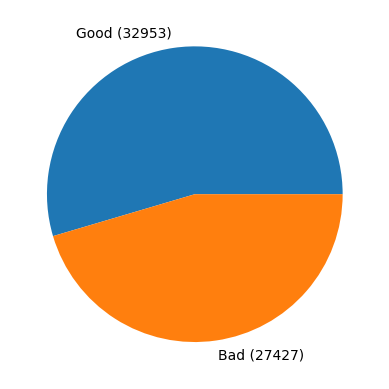

In [8]:
labels = raw_data.apply(calculate_video_success, axis=1, result_type="reduce", args=(THRESHOLD,))

amts = labels.value_counts()

plt.pie(amts, labels=[f"{'Good' if x == 1 else 'Bad'} ({amts.loc[x]})" for x in amts.keys()])

As shown in the pie chart above, the data is split roughly evenly with a threshold of 2.5%.

### Methods

This section will contain most of the models and all its dependencies.

#### Models
As mentioned, the fabricated model takes two inputs: a video’s thumbnail and its title. The transformed text and image inputs indicate that the input data dimension will be large. A convolutional neural network with additional dense layers was used for the image input. A pre-trained BERT model with additional dense layers was used for the text input model. These two models were concatenated and attached to more dense layers. The output of this unified model was used for the final model. 

A convolutional neural network was used for the images as it allows for the features of the images to be identified and processed instead of just the raw pixel values. This allows for a more contextual interpretation of the image, which will boost model performance.

A pre-trained BERT model is used for the text input to extract contextual meaning from the video title. This is performs better than a simple one hot encoded vector. It is more dense and minimizes the cosine distance between similar words.

K-fold cross-validation will be used to verify a model's accuracy. It builds different models and tests the accuracy of each model. The overall performance on all these models will be averaged and used as a performance metric. An evaluation of which configuration of hyperparameters will produce a more accurate model will yield the final chosen model. 

Two submodels were made to handle the image and text inputs seperately. Later, these models will be merged for the final model.

##### Image-Only Model

In [36]:
# Image Portion
def generate_image_model():
	"""
	Generate Image-Only Model

	Returns
	=======
	The image model, its input layer, and last hidden state layer
	"""
	img_input = Input((90, 120, 3), name="image_inputs")
	x = Conv2D(32, 5, activation='relu', padding='same')(img_input)
	x = MaxPooling2D()(x)
	x = Conv2D(64, 4, activation='relu', padding='same')(x)
	x = MaxPooling2D()(x)
	x = Conv2D(128, 3, activation='relu', padding='same')(x)
	x = MaxPooling2D()(x)
	x = Flatten()(x)
	x = Dense(64, activation='relu')(x)
	x = Dropout(0.5)(x)
	x = Dense(32, activation='relu')(x)
	x_out = Dropout(0.5)(x)
	img_output = Dense(1, activation='sigmoid')(x_out)

	img_model = Model(inputs=img_input, outputs=img_output, name="img_model")

	return img_model, img_input, x

Model: "img_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_inputs (InputLayer)   [(None, 90, 120, 3)]      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 120, 32)       2432      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 45, 60, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 45, 60, 64)        32832     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 22, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 22, 30, 128)       73

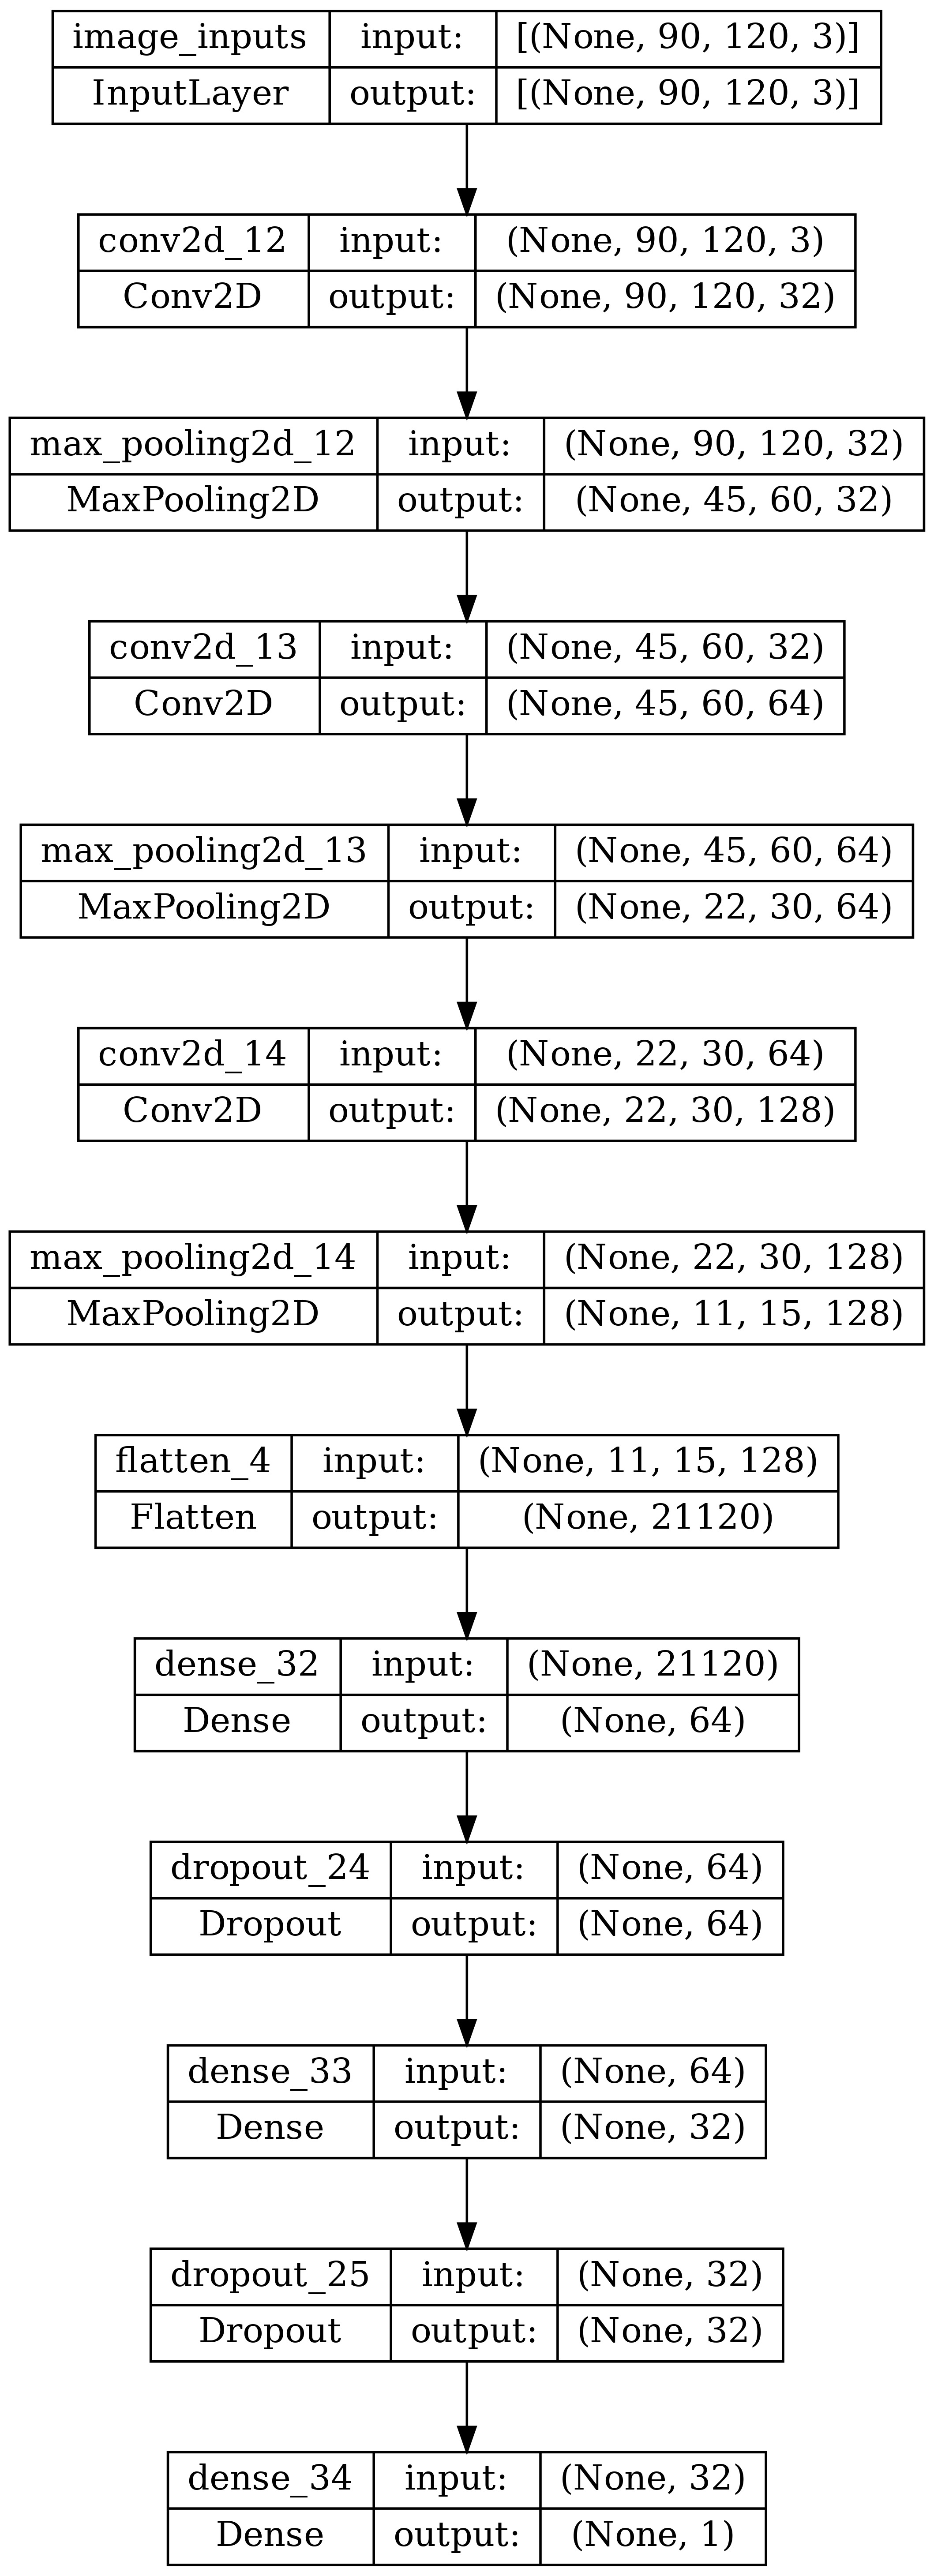

In [37]:
img_model, _, _ = generate_image_model()
img_model.summary()
plot_model(img_model, to_file='img_model.png', show_shapes=True, dpi=400)

##### Text-Only Model

In [38]:
# Text Portion
def generate_text_model():
	"""
	Generate Text-Only Model

	Returns
	=======
	The text model, its input layers, and last hidden state layer
	"""
	text_input = Input(shape=(10,), dtype=tf.int32, name="text_inputs")
	attention_mask = Input(shape=(10,), dtype=tf.int32, name="attention_masks")

	transformer_output = bert_model(text_input, attention_mask=attention_mask)

	# y = transformer_output.last_hidden_state[:, 0, :]
	y = transformer_output.pooler_output

	y = Dense(64, activation='relu')(y)
	y = Dropout(0.5)(y)
	y = Dense(32, activation='relu')(y)
	y_out = Dropout(0.5)(y)
	text_output = Dense(1, activation='sigmoid')(y_out)

	text_model = Model(inputs=[text_input, attention_mask], outputs=text_output, name="text_model")

	return text_model, [text_input, attention_mask], y

Model: "text_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_inputs (InputLayer)    [(None, 10)]                 0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 10)]                 0         []                            
 r)                                                                                               
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['text_inputs[0][0]',         
 )                           ngAndCrossAttentions(last_   40         'attention_masks[0][0]']     
                             hidden_state=(None, 10, 76                                  

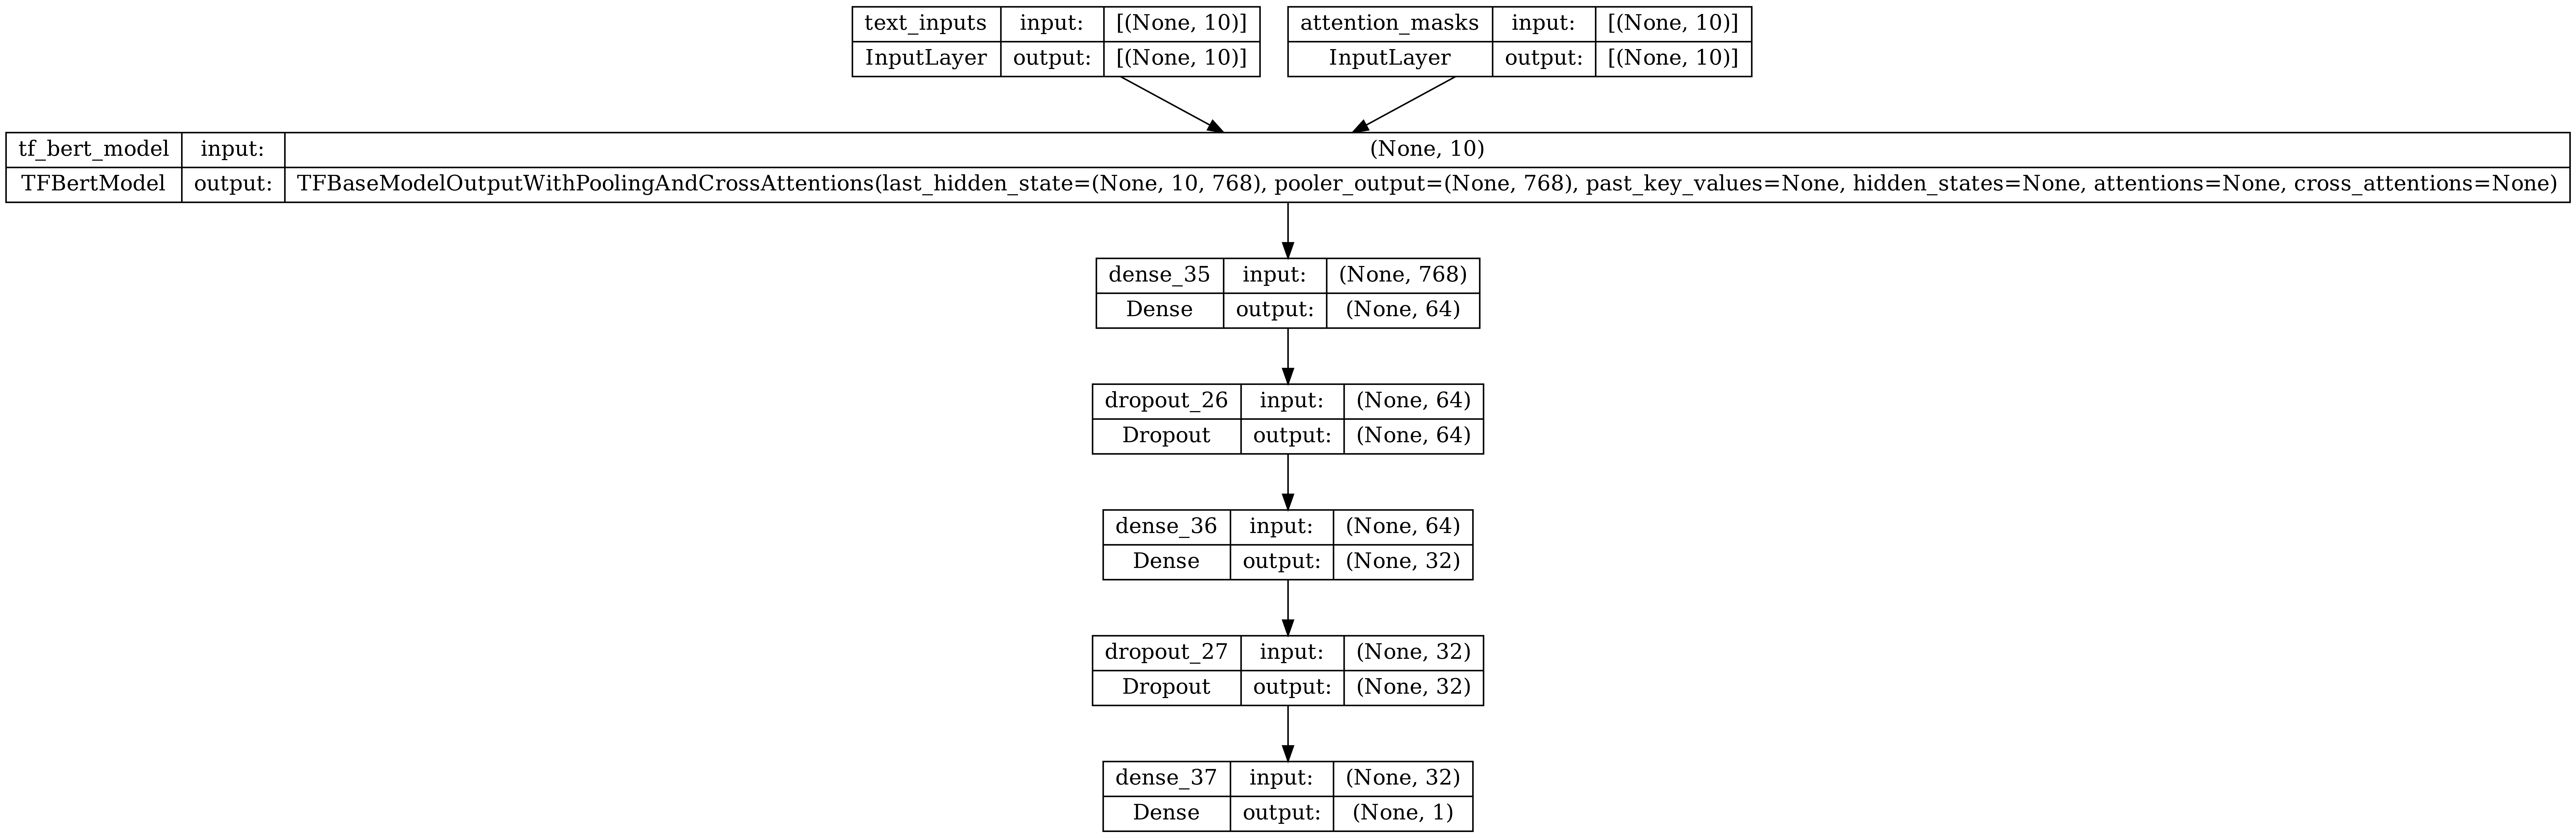

In [39]:
text_model, _, _ = generate_text_model()
text_model.summary()
plot_model(text_model, to_file='text_model.png', show_shapes=True, dpi=400)

##### United Model

In [40]:
# United Model
def generate_united_model():
	"""
	Generate Complete Model with both text and image inputs

	Returns
	=======
	The complete model, its input layers, and last hidden state layer
	"""
	# Img Portion
	_, img_input, x = generate_image_model()
	# Text Portion
	_, text_inputs, y = generate_text_model()

	# Inputs
	inputs = [img_input, *text_inputs]

	# Merge
	z = Concatenate()([x, y])
	z = Dropout(0.5)(z)
	z = Dense(32, activation='relu')(z)
	z = Dropout(0.5)(z)
	z = Dense(1, activation='sigmoid')(z)

	united_model = Model(inputs=inputs, outputs=z, name="united_model")

	return united_model, inputs, z

In [41]:
united_model, _, _ = generate_united_model()
united_model.summary()
plot_model(united_model, to_file='united_model.png', show_shapes=True, dpi=400)

Model: "united_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_inputs (InputLayer)   [(None, 90, 120, 3)]         0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 90, 120, 32)          2432      ['image_inputs[0][0]']        
                                                                                                  
 max_pooling2d_15 (MaxPooli  (None, 45, 60, 32)           0         ['conv2d_15[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 45, 60, 64)           32832     ['max_pooling2d_15[

#### Generators
To lower memory usage, the dataset needs to be batched. This is done through the use of data generators. The image processing also happens in the generator to minimize the amount of data loaded into system memory.

To transform the image in the dataset, it needs to be normalized. This can be done by dividing all the RGB values by 255. Since the highest value an RGB value can be is 255, this will rescale the values to be between $[0, 1]$. This will make the image easier to handle for the model as the model will not need to handle big values.

##### Thumbnail Data Generator
This generator is for the image-only model

In [15]:
class ThumbnailDataGenerator(Sequence):

	def __init__(self, 
			  filedir : str, 
			  list_IDs : pd.Series, 
			  labels : pd.Series, 
			  rescale : float=255.0, 
			  filetype : str="jpg", 
			  batch_size : int=32, 
			  dim : tuple[int, int]=(90, 120), 
			  shuffle=True
		):
		'''
		Data Generator Initialization Function 
		'''
		# File Location & Info
		self.filedir = filedir
		self.filetype = filetype

		# Image Settings
		self.dim = dim
		self.rescale = rescale

		# Batching
		self.batch_size = batch_size
		self.shuffle = shuffle

		# Datasets
		self.labels = labels
		self.list_IDs = list_IDs

		self.on_epoch_end()

	def on_epoch_end(self):
		'''
		Updates indexes after each epoch
		'''
		self.indexes = np.arange(len(self.list_IDs))

		# Randomize if Shuffle
		if self.shuffle:
			np.random.shuffle(self.indexes)

	def __data_generation(self, list_IDs_temp):
		'''
		Generates data containing batch_size samples
		'''
		# Initialization
		X = np.empty((self.batch_size, *self.dim, 3))
		y = np.empty((self.batch_size), dtype=float)

		# Generate data
		for i, ID in enumerate(list_IDs_temp):
			# Store sample
			X[i,] = Image.open(f'{self.filedir}/{ID}.{self.filetype}').convert("RGB")

			# Store class
			y[i] = self.labels[ID]

		# Rescale
		X /= self.rescale

		return X, y
	
	def __len__(self):
		'''
		Denotes the number of batches per epoch
		'''
		return int(np.floor(len(self.list_IDs) / self.batch_size))
	
	def __getitem__(self, index):
		'''
		Generate one batch of data
		'''
		# Generate indexes of the batch
		indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

		# Find list of IDs
		list_IDs_temp = [self.list_IDs.iloc[k] for k in indexes]

		# Generate data
		return self.__data_generation(list_IDs_temp)

##### Thumbnail and Title Data Generator
The following generator is meant to handle both images and text inputs. It will be used for the united model. As a result, it will also handle the title vectorization process.

In [16]:
class ThumbnailTitleDataGenerator(Sequence):

	def __init__(self, 
			  filedir : str, 
			  list_IDs : pd.Series, 
			  texts : pd.Series, 
			  labels : pd.Series, 
			  rescale : float=255.0, 
			  filetype : str="jpg", 
			  batch_size : int=32, 
			  img_dim : tuple[int, int]=(90, 120), 
			  text_dim : int=10, 
			  tokenizer : BertTokenizer=None,
			  img_input_name : str="image_inputs",
			  text_input_name : str="text_inputs",
			  attention_input_name : str="attention_masks",
			  shuffle=True
		):
		'''
		Data Generator Initialization Function 
		'''
		# File Location & Info
		self.filedir = filedir
		self.filetype = filetype

		# Dimensions
		self.img_dim = img_dim
		self.text_dim = text_dim
		self.rescale = rescale

		# Batching
		self.batch_size = batch_size
		self.shuffle = shuffle

		# Datasets
		self.labels = labels
		self.list_IDs = list_IDs
		self.texts = texts
		self.tokenizer = tokenizer

		# Input Names
		self.img_input_name = img_input_name
		self.text_input_name = text_input_name
		self.attention_input_name = attention_input_name

		self.on_epoch_end()

	def on_epoch_end(self):
		'''
		Updates indexes after each epoch
		'''
		self.indexes = np.arange(len(self.list_IDs))

		# Randomize if Shuffle
		if self.shuffle:
			np.random.shuffle(self.indexes)

	def __data_generation(self, list_IDs_temp : list[str]):
		'''
		Generates data containing batch_size samples
		'''
		# Initialization
		X_IMG = np.empty((self.batch_size, *self.img_dim, 3))
		X_TEXT = np.empty((self.batch_size, self.text_dim))
		X_ATTENTION = np.empty((self.batch_size, self.text_dim))
		y = np.empty((self.batch_size), dtype=float)

		# Generate data
		temp_titles : list[str] = [None] * self.batch_size
		for i, ID in enumerate(list_IDs_temp):
			# Store sample
			X_IMG[i,] = Image.open(f'{self.filedir}/{ID}.{self.filetype}').convert("RGB")

			# Process title
			temp_titles[i] = self.texts[ID]

			# Store class
			y[i] = self.labels[ID]

		# Rescale
		X_IMG /= self.rescale

		# Encode Text
		encoded_text = self.tokenizer(temp_titles, padding=True, truncation=True, max_length=self.text_dim)
		X_TEXT[:,:] = encoded_text["input_ids"]
		X_ATTENTION[:,:] = encoded_text["attention_mask"]

		# Unify Inputs
		X = {
			self.img_input_name: X_IMG,
			self.text_input_name: X_TEXT,
			self.attention_input_name: X_ATTENTION
		}

		return X, y
	
	def __len__(self):
		'''
		Denotes the number of batches per epoch
		'''
		return int(np.floor(len(self.list_IDs) / self.batch_size))
	
	def __getitem__(self, index):
		'''
		Generate one batch of data
		'''
		# Generate indexes of the batch
		indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

		# Find list of IDs
		list_IDs_temp = [self.list_IDs.iloc[k] for k in indexes]

		# Generate data
		return self.__data_generation(list_IDs_temp)

#### Training
The models will undergo a 5-fold cross validation with a maximum epoch of 30 for training. It can be less epoches with the early stop callback.

##### Image-Only Training

In [31]:
# Image Model
kf = KFold(n_folds)

img_validation_accuracy = []
img_validation_loss = []

fold_var = 1
for train, val in kf.split(thumbnail_ids, labels):
	# Fold Indicator
	print(f"Starting k-Fold #{fold_var}")
	
	# Clear Keras
	clear_session()

	# Make image model for testing
	img_model, _, _ = generate_image_model()
	lr_schedule = ExponentialDecay(initial_learning_rate=learning_rate, decay_steps=10000, decay_rate=0.9)
	img_model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

	# Callback Saving
	checkpoint = ModelCheckpoint(f"{modeldir}/img-model_{fold_var}.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
	early_stop = EarlyStopping(monitor='val_loss', patience=10)

	# Generator
	tbdg_train = ThumbnailDataGenerator(dirpath, thumbnail_ids.iloc[train], labels.iloc[train], batch_size=batch_size)
	tbdg_validate = ThumbnailDataGenerator(dirpath, thumbnail_ids.iloc[val], labels.iloc[val], batch_size=batch_size)

	# Fit
	history = img_model.fit(x=tbdg_train, validation_data=tbdg_validate, callbacks=[checkpoint, early_stop], epochs=epochs)

	# Grab Results
	img_model.load_weights(f"{modeldir}/img-model_{fold_var}.h5")
	
	results = img_model.evaluate(x=tbdg_validate)
	results = dict(zip(img_model.metrics_names, results))
	
	img_validation_accuracy.append(results['accuracy'])
	img_validation_loss.append(results['loss'])

	# Increment
	fold_var += 1

Starting k-Fold #1
Epoch 1/30
3019/3019 [==============================] - ETA: 0s - loss: 0.6800 - accuracy: 0.5720 - precision: 0.5635 - recall: 0.9514
Epoch 1: val_accuracy improved from -inf to 0.60071, saving model to models/img-model_1.h5
3019/3019 [==============================] - 44s 14ms/step - loss: 0.6800 - accuracy: 0.5720 - precision: 0.5635 - recall: 0.9514 - val_loss: 0.6679 - val_accuracy: 0.6007 - val_precision: 0.5832 - val_recall: 0.9596
Epoch 2/30
3015/3019 [============================>.] - ETA: 0s - loss: 0.6516 - accuracy: 0.6153 - precision: 0.6072 - recall: 0.8321
Epoch 2: val_accuracy improved from 0.60071 to 0.65177, saving model to models/img-model_1.h5
3019/3019 [==============================] - 41s 14ms/step - loss: 0.6514 - accuracy: 0.6155 - precision: 0.6074 - recall: 0.8321 - val_loss: 0.6218 - val_accuracy: 0.6518 - val_precision: 0.6595 - val_recall: 0.7568
Epoch 3/30
3016/3019 [============================>.] - ETA: 0s - loss: 0.6085 - accuracy: 0

In [32]:
a = np.array(img_validation_accuracy)
l = np.array(img_validation_loss)

print(f"Average Accuracy: {a.mean()} | Average Loss: {l.mean()}")

Average Accuracy: 0.7343501329421998 | Average Loss: 0.5690737128257751


##### Text-Only Training

In [ ]:
# Text Model
kf = KFold(n_folds)

text_validation_accuracy = []
text_validation_loss = []

fold_var = 1
for train, val in kf.split(input_texts["input_ids"], labels):
	# Fold Indicator
	print(f"Starting k-Fold #{fold_var}")
	
	# Clear Keras
	clear_session()

	# Make image model for testing
	text_model, _, _ = generate_text_model()
	lr_schedule = ExponentialDecay(initial_learning_rate=learning_rate, decay_steps=10000, decay_rate=0.9)
	text_model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])

	# Callback Saving
	checkpoint = ModelCheckpoint(f"{modeldir}/text-model_{fold_var}.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
	early_stop = EarlyStopping(monitor='val_loss', patience=10)

	# Train / Validation
	trainset = {
		"text_inputs": tf.gather(input_texts["input_ids"], indices=train), 
		"attention_masks": tf.gather(input_texts["attention_mask"], indices=train)
	}
	testset = {
		"text_inputs": tf.gather(input_texts["input_ids"], indices=val), 
		"attention_masks": tf.gather(input_texts["attention_mask"], indices=val)
	}

	# Fit
	history = text_model.fit(x=trainset, y=labels.iloc[train], validation_data=(testset, labels.iloc[val]), callbacks=[checkpoint, early_stop], epochs=epochs, batch_size=batch_size)

	# Grab Results
	text_model.load_weights(f"{modeldir}/text-model_{fold_var}.h5")
	
	results = text_model.evaluate(x=testset, y=labels.iloc[val])
	results = dict(zip(text_model.metrics_names, results))
	
	text_validation_accuracy.append(results['accuracy'])
	text_validation_loss.append(results['loss'])

	# Increment
	fold_var += 1

Starting k-Fold #1
Epoch 1/30
3018/3019 [============================>.] - ETA: 0s - loss: 0.6915 - accuracy: 0.5425
Epoch 1: val_accuracy improved from -inf to 0.54960, saving model to models/text-model_1.h5
3019/3019 [==============================] - 122s 38ms/step - loss: 0.6915 - accuracy: 0.5425 - val_loss: 0.6888 - val_accuracy: 0.5496
Epoch 2/30
3019/3019 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.5447
Epoch 2: val_accuracy did not improve from 0.54960
3019/3019 [==============================] - 113s 38ms/step - loss: 0.6905 - accuracy: 0.5447 - val_loss: 0.6884 - val_accuracy: 0.5496
Epoch 3/30
3019/3019 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5445
Epoch 3: val_accuracy improved from 0.54960 to 0.54969, saving model to models/text-model_1.h5
3019/3019 [==============================] - 112s 37ms/step - loss: 0.6896 - accuracy: 0.5445 - val_loss: 0.6877 - val_accuracy: 0.5497
Epoch 4/30
3018/3019 [===================

In [ ]:
a = np.array(text_validation_accuracy)
l = np.array(text_validation_loss)

print(f"Average Accuracy: {a.mean()} | Average Loss: {l.mean()}")

Average Accuracy: 0.5838 | Average Loss: 0.6748999999999998


##### United Training

In [22]:
# United Model
kf = KFold(n_folds)

united_validation_accuracy = []
united_validation_loss = []

fold_var = 1
for train, val in kf.split(thumbnail_ids, labels):
	# Fold Indicator
	print(f"Starting k-Fold #{fold_var}")
	
	# Clear Keras
	clear_session()

	# Make image model for testing
	united_model, _, _ = generate_united_model()
	lr_schedule = ExponentialDecay(initial_learning_rate=learning_rate, decay_steps=10000, decay_rate=0.9) 
	united_model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

	# Callback Saving
	checkpoint = ModelCheckpoint(f"{modeldir}/complete-model_{fold_var}.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
	early_stop = EarlyStopping(monitor='val_loss', patience=10)

	# Generator
	tbtdg_train = ThumbnailTitleDataGenerator(dirpath, thumbnail_ids.iloc[train], raw_data["title"].iloc[train], labels.iloc[train], batch_size=batch_size, tokenizer=bert_tokenizer)
	tbtdg_validate = ThumbnailTitleDataGenerator(dirpath, thumbnail_ids.iloc[val], raw_data["title"].iloc[val], labels.iloc[val], batch_size=batch_size, tokenizer=bert_tokenizer)

	# Fit
	history = united_model.fit(x=tbtdg_train, validation_data=tbtdg_validate, callbacks=[checkpoint, early_stop], epochs=epochs)

	# Grab Results
	united_model.load_weights(f"{modeldir}/complete-model_{fold_var}.h5")
	
	results = united_model.evaluate(x=tbtdg_validate)
	results = dict(zip(united_model.metrics_names, results))
	
	united_validation_accuracy.append(results['accuracy'])
	united_validation_loss.append(results['loss'])

	# Increment
	fold_var += 1

Starting k-Fold #1
Epoch 1/30
3019/3019 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.5427 - precision: 0.5477 - recall: 0.9209
Epoch 1: val_accuracy improved from -inf to 0.61116, saving model to models/complete-model_1.h5


/home/chairmanpooh/YT-ML/.venv/lib/python3.11/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3019/3019 [==============================] - 297s 94ms/step - loss: 0.6892 - accuracy: 0.5427 - precision: 0.5477 - recall: 0.9209 - val_loss: 0.6719 - val_accuracy: 0.6112 - val_precision: 0.5927 - val_recall: 0.9347
Epoch 2/30
3019/3019 [==============================] - ETA: 0s - loss: 0.6700 - accuracy: 0.5936 - precision: 0.5978 - recall: 0.7763
Epoch 2: val_accuracy improved from 0.61116 to 0.62906, saving model to models/complete-model_1.h5
3019/3019 [==============================] - 281s 93ms/step - loss: 0.6700 - accuracy: 0.5936 - precision: 0.5978 - recall: 0.7763 - val_loss: 0.6579 - val_accuracy: 0.6291 - val_precision: 0.6717 - val_recall: 0.6365
Epoch 3/30
3019/3019 [==============================] - ETA: 0s - loss: 0.6437 - accuracy: 0.6392 - precision: 0.6522 - recall: 0.7237
Epoch 3: val_accuracy improved from 0.62906 to 0.67382, saving model to models/complete-model_1.h5
3019/3019 [==============================] - 282s 93ms/step - loss: 0.6437 - accuracy: 0.6392 - 

In [ ]:
a = np.array(united_validation_accuracy)
l = np.array(united_validation_loss)

print(f"Average Accuracy: {a.mean()} | Average Loss: {l.mean()}")

Average Accuracy: 0.7301500000000001 | Average Loss: 0.588075


##### Final Training
Once all the models have been trained and analysised with k-fold cross validation, the final model will be trained with a bigger portion of the dataset. It will then be tested again. This is explored in the next section.

### Results

#### Testing with "New Data"
Once a final model has been trained, it must be tested with new data. This can be collected from the YouTube API or the division between the training and testing dataset can be further skwed. 

For the YouTube API option, the new data will also undergo filtering and processing as needed. Their thumbnails will also need to be downloaded. 

For the skwed dataset option, the existing dataset can be adjusted so that more data is allocated towards training than the default split of $80:20$. A new split can be $95:5$.

For simplicity sake, this project will readjust the dataset split. The split will also be as balanced as possible with an even spread of true and false labels.

In [18]:
# Split Dataset
kf = StratifiedKFold(20, shuffle=True) # 19:1 = 95:5
train, val = list(kf.split(thumbnail_ids, labels))[0] # Use only one split for final model

# Clear Keras
clear_session()

# Make image model for testing
united_model, _, _ = generate_united_model()
lr_schedule = ExponentialDecay(initial_learning_rate=learning_rate, decay_steps=10000, decay_rate=0.9) 
united_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Callback Saving
checkpoint = ModelCheckpoint(f"{modeldir}/final-complete-model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Generator
tbtdg_train = ThumbnailTitleDataGenerator(dirpath, thumbnail_ids.iloc[train], raw_data["title"].iloc[train], labels.iloc[train], batch_size=batch_size, tokenizer=bert_tokenizer)
tbtdg_validate = ThumbnailTitleDataGenerator(dirpath, thumbnail_ids.iloc[val], raw_data["title"].iloc[val], labels.iloc[val], batch_size=batch_size, tokenizer=bert_tokenizer)

# Fit
united_model.fit(x=tbtdg_train, validation_data=tbtdg_validate, callbacks=[checkpoint, early_stop], epochs=epochs)

The validation indexes are saved so that they may be used later for testing purposes.

In [19]:
val.sort()
np.savetxt("val.csv", val, delimiter=",")

#### Load Weights from Model
The latest weights need to be loaded into an empty model to test the new data.

In [33]:
# Generate a new model
final_model, _, _ = generate_united_model()

# Load weights form h5 file
final_model.load_weights(f"{modeldir}/final-complete-model.h5")

# Make Generator
val = np.genfromtxt("val.csv", delimiter=",")
val = val[:-11] # Batching will cut off some entries
tbtdg_validate = ThumbnailTitleDataGenerator(dirpath, thumbnail_ids.iloc[val], raw_data["title"].iloc[val], labels.iloc[val], batch_size=batch_size, tokenizer=bert_tokenizer, shuffle=False)

# Evaluate model
predictions = final_model.predict(x=tbtdg_validate)

188/188 [==============================] - 16s 63ms/step


The predictions need to be rounded to the nearest integer (0 or 1) so that they may be used to calculate the confusion matrix.

In [34]:
class_predictions = predictions.round()

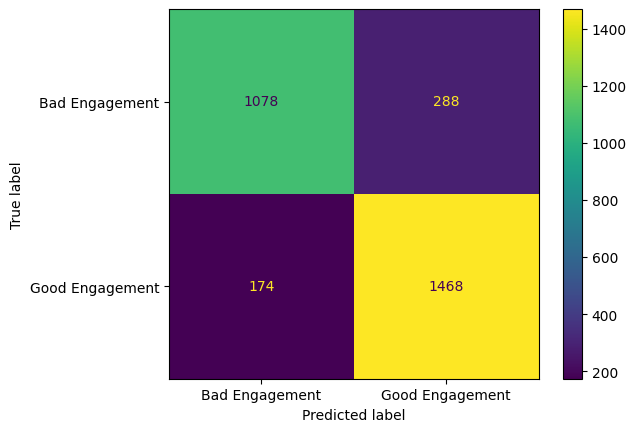

In [35]:
cm = confusion_matrix(y_true=labels.iloc[val], y_pred=class_predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=["Bad Engagement", "Good Engagement"])
disp.plot()

#### Analysis
Upon training completion, the model that accepts both an image and a text input stabilizes at an accuracy of 73%. The image only model converged at around 73% while the text only model is at 58%. These values were reached after many adjustments to the model. These actions ranged from adding and removing dense layers, adjusting the amount of parameters within these layers, adjusting the optimizer, increasing the epoch, changing the data labeling method, and increasing the amount of data that was acquired.

For adjusting the model parameters, adding new dense layers would increase the number of "neurons" in a model. This would make it better at detecting patterns. However, this lead to overfitting on the training data, with little to negative improvement with validation data. Removing a dense layer also makes the model worse as it has a harder time finding any patterns. Increasing and decreasing the amount of neurons in the pre-existing layers have a similar effect. To adjust the optimizer means adjusting the learning rate. This model used the Adam optimizer at first, which has a adaptive learning rate. However, it did worse than using an exponential decay learning rate. This can happen because the Adam optimizer could not adapt to the model fast enough compared to the decay schedule.

Increasing the epoch was a good decision as it allowed the model to learn more from the training data. Of course, this may lead to overfitting. As a result, an early stop callback was added to stop the learning process early if the validation data started to preform worse after multiple epoches. This was used in conjuntion with a model checkpoint callback. This saved the weights from the current epoch if the validation data preformed better than the previous epoch. Thus, the best model will always be saved.

The "success" metric changed a few times as well. It ranged from just the view count, to its current form with the engagement rate of the video. The first metric (view count only) worked, but was found to be a poor indicator of success, as a video with a lot of views may be hated by its viewers, and could result in a poorer reception in a channel's future videos. Thus, the metric changed to become the sum of the likes and comments on a video, normalized to its view count alongside a threshold of 2.5%. This makes the labeling more accurate to the definition of "success".

The 58% accuracy from the text model, after several adjustments, may be an indicator to the lack of significant correlation between the title and the video’s engagement rate. This can be explained as the title is usually only seen before the video is selected for viewing by the viewer. Afterwards, the video content itself would be a bigger factor in controlling video engagement.

The 73% accuracy from the image model shows that a video’s thumbnail has a bigger impact on the engagement rate of a video compared to the video’s title. This can be interpreted as the thumbnail having a greater effect on influencing the viewers, and can promote more engagement. Of course, this is still not that high, the viewer will favour the video’s content more than the video’s thumbnail.

Finally, the combined model had an accuracy of 73%. This is almost identical to the image-only model. This more justification to the idea that the title had little impact on the success metric of engagement. Based on the confusion matrix, it seems that the model tends to make more false positives over false negatives. This indicates that the model tends to overestimate a video's success than underestimate it. This can be due to the labeling threshold, as it was not a perfect split between bad and good videos.

### Conclusion

The final unified model that was created is only about 73% accuracy. This may be due to a lack of correlation between the inputs of the model (video thumbnail and title) and its label (video’s engagement according to its likes and comments count). It could also be an issue with the data. If more time was possible, more data could have been gathered to give the model more chances to detect patterns. Additional hyperparameter modifications could have occurred with additional time, such as creating a custom embedding and tokenizer rather than using the pre-trained BERT model. It would allow for a more custom solution to this unique problem. 

In the meantime, if the result is taken at face value, what this means is that a content creator that aims to increase engagement through more likes and comments can focus less on a video’s title, as it has negligible correlation with a video’s engagement rate. A video’s thumbnail is relatively more impactful according to the findings of this project. Of course, the most important part to increasing engagement lies in other parts of the video, namely the content itself. Novice content creators should focus on making quality content, rather than optimizing their thumbnail or title as a shortcut to success.

An alternative approach to success rate and business insights might be to perform topic identification on the dataset. For example, each title might refer to a specific event in time or, for chess videos in particular, a genre of videos that viewers generally find interesting. Focussing on topic identification might also be useful for content creators seeking to understand what trends are or were popular for different video genres. Another direction that could be taken is accounting for time-variant parameters. This includes views, as well as likes and comment ratios. The decided label parameter in this project was the relative ratio of likes and comments to views. This was chosen as this “engagement rate” is not strictly dependent on time. For a label such as “views,” one would need to account for accumulated views over a given period. This analysis is difficult to perform with current dataset, but perhaps enhancing the dataset with historical view data for videos or channels could allow this analysis to be performed. Some alternative approaches to success rate and business insights

For the future, more adjustments to the model can be performed to increase accuracy. More data from other channels can also be queried. Other subgenres could also be explored as this result only focuses on chess-related videos. Another improvement that could be done is to train a custom embedding model instead of using the pre-trained BERT model. This could allow the model to specialize from sentences to titles as BERT was designed to extract context from passages instead of short phrases. Experiments with a pre-trained CNN like RasNet-20 could also be done on the image-only model to increase feature extraction and model performance.

### Bibliography

API Reference | YouTube Data API | Google for Developers. (n.d.). Google for Developers. https://developers.google.com/youtube/v3/docs

NLTK :: nltk package. (n.d.). https://www.nltk.org/api/nltk.html

Pretrained models — transformers 3.3.0 documentation. (n.d.). https://huggingface.co/transformers/v3.3.1/pretrained_models.html